# Chapter 4

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# check if the libraries we need are installed

try:
    import pint
except ImportError:
    !pip install pint
    import pint
    
try:
    import modsim
except ImportError:
    !pip install modsimpy
    from modsim import *

Here the code from previous chapters we'll reuse.

In [2]:
from modsim import flip

def step(state, p1, p2):
    """Simulate one time step.
    
    state: bikeshare State object
    p1: probability of an Olin->Wellesley ride
    p2: probability of a Wellesley->Olin ride
    """
    if flip(p1):
        bike_to_wellesley(state)
    
    if flip(p2):
        bike_to_olin(state)

In [3]:
def bike_to_olin(state):
    """Move one bike from Wellesley to Olin.
    
    state: bikeshare State object
    """
    if state.wellesley == 0:
        state.wellesley_empty += 1
        return
    state.wellesley -= 1
    state.olin += 1

In [4]:
def bike_to_wellesley(state):
    """Move one bike from Olin to Wellesley.
    
    state: bikeshare State object
    """
    if state.olin == 0:
        state.olin_empty += 1
        return
    state.olin -= 1
    state.wellesley += 1

In the previous chapter we defined metrics that quantify the performance of bike sharing this system. In this chapter we see how those metrics depend on the parameters of the system, like the arrival rate of customers at bike stations.

We also discuss a program development strategy, called incremental
development, that might help you write programs faster and spend less
time debugging.

## Functions that return values

We have seen several functions that return values; for example, when you run `sqrt`, it returns a number you can assign to a variable.

In [5]:
from numpy import sqrt

root_2 = sqrt(2)
root_2

1.4142135623730951

When you run `State`, it returns a new `State` object:

In [6]:
from modsim import State

bikeshare = State(olin=10, wellesley=2)
bikeshare

,values
olin,10
wellesley,2


Not all functions have return values. For example, when you run `step`,
it updates a `State` object, but it doesn't return a value.

To write functions that return values, we can use a `return` statement, like this:

In [7]:
def add_five(x):
    return x + 5

`add_five` takes a parameter, `x`, which could be any number. It
computes `x + 5` and returns the result. So if we run it like this, the
result is `8`:

In [8]:
add_five(3)

8

As a more useful example, here's a version of `run_simulation` that
creates a `State` object, runs a simulation, and then returns the
`State` object:

In [9]:
from modsim import TimeSeries

def run_simulation(p1, p2, num_steps):
    state = State(olin=10, wellesley=2,
                  olin_empty=0, wellesley_empty=0)
    
    for i in range(num_steps):
        step(state, p1, p2)
        
    return state

We can call `run_simulation` like this:

In [10]:
final_state = run_simulation(0.3, 0.2, 60)

The result is a `State` object that represents the final state of the system, including the metrics we'll use to evaluate the performance of the system:

In [11]:
print(final_state.olin_empty, 
      final_state.wellesley_empty)

0 1


The simulation we just ran starts with `olin=10` and `wellesley=2`, and uses the values `p1=0.3`, `p2=0.2`, and `num_steps=60`. 
These five values are **parameters of the model**, which are quantities that determine the behavior of the system.

It is easy to get the parameters of a model confused with the parameters of a function. 
In fact, it is common for the parameters of the model to appear as parameters in functions. 

For example, the previous version of `run_simulation` takes `p1`, `p2`, and `num_steps` as parameters.
So we can call `run_simulation` with different parameters and see how
the metrics, like the number of unhappy customers, depend on the
parameters. But before we do that, we need a new version of a `for` loop.

## Loops and arrays

In `run_simulation`, we use this `for` loop:

```
    for i in range(num_steps):
        step(state, p1, p2)
```

In this example, `range` creates a sequence of numbers from 0 to `num_steps` (including `0` but not `num_steps`). 
Each time through the loop, the next number in the sequence gets assigned to the loop variable, `i`.

But `range` only works with integers; to get a sequence of non-integer
values, we can use `linspace`, which is defined NumPy:

In [12]:
from numpy import linspace

p1_array = linspace(0, 1, 5)
p1_array

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

The arguments indicate where the sequence should start and stop, and how
many elements it should contain. In this example, the sequence contains
`5` equally-spaced numbers, starting at `0` and ending at `1`.

The result is a NumPy **array**, which is a new kind of object we have
not seen before. An array is a container for a sequence of numbers.

We can use an array in a `for` loop like this:

In [13]:
for p1 in p1_array:
    print(p1)

0.0
0.25
0.5
0.75
1.0


When this loop runs, it

1.  Gets the first value from the array and assigns it to `p1`.

2.  Runs the body of the loop, which prints `p1`.

3.  Gets the next value from the array and assigns it to `p1`.

4.  Runs the body of the loop, which prints `p1`.

And so on, until it gets to the end of the array. This will come in handy in the next section.

## Sweeping parameters

If we know the actual values of parameters like `p1` and `p2`, we can
use them to make specific predictions, like how many bikes will be at
Olin after one hour.

But prediction is not the only goal; models like this are also used to
explain why systems behave as they do and to evaluate alternative
designs. For example, if we observe the system and notice that we often run out of bikes at a particular time, we could use the model to figure out why that happens. And if we are considering adding more bikes, or another station, we could evaluate the effect of various "what if" scenarios.

As an example, suppose we have enough data to estimate that `p2` is
about `0.2`, but we don't have any information about `p1`. We could run simulations with a range of values for `p1` and see how the results vary. This process is called **sweeping** a parameter, in the sense that the value of the parameter "sweeps" through a range of possible values.

Now that we know about loops and arrays, we can use them like this:

In [14]:
p1_array = linspace(0, 0.6, 6)
p2 = 0.2
num_steps = 60

for p1 in p1_array:
    final_state = run_simulation(p1, p2, num_steps)
    print(p1, final_state.olin_empty)

0.0 0
0.12 0
0.24 0
0.36 0
0.48 7
0.6 7


Each time through the loop, we run a simulation with a different value
of `p1` and the same value of `p2`, `0.2`. Then we print `p1` and the
number of unhappy customers at Olin.

To save and plot the results, we can use a `SweepSeries` object, which
is similar to a `TimeSeries`; the difference is that the labels in a
`SweepSeries` are parameter values rather than time values.

We can create an empty `SweepSeries` like this:

In [15]:
from modsim import SweepSeries

sweep = SweepSeries()

And add values like this:

In [16]:
for p1 in p1_array:
    final_state = run_simulation(p1, p2, num_steps)
    sweep[p1] = final_state.olin_empty

The result is a `SweepSeries` that maps from each value of `p1` to the
resulting number of unhappy customers. Then we can plot the results:

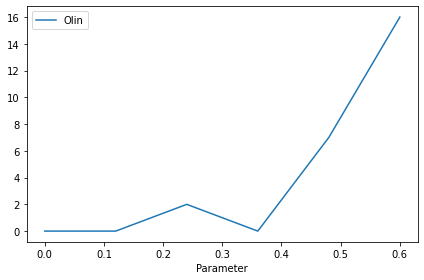

In [17]:
from modsim import plot

plot(sweep, label='Olin')

NumPy provides functions that compute a variety of summary statistics, like `mean`, `median`, and `std` (which computes standard deviation).

We can use `mean` to compute the average of the values in a series, like this:

In [18]:
from numpy import mean

mean(sweep)

4.166666666666667

In this example, computing the mean might not be useful, but in the exercises below, it will be.

## Incremental development

When you start writing programs that are more than a few lines, you
might find yourself spending more and more time debugging. The more code you write before you start debugging, the harder it is to find the problem.

**Incremental development** is a way of programming that tries to
minimize the pain of debugging. The fundamental steps are:

1.  Always start with a working program. If you have an example from a
    book, or a program you wrote that is similar to what you are working
    on, start with that. Otherwise, start with something you *know* is
    correct, like `x=5`. Run the program and confirm that it does what
    you expect.

2.  Make one small, testable change at a time. A "testable" change is
    one that displays something or has some other effect you can check.
    Ideally, you should know what the correct answer is, or be able to
    check it by performing another computation.

3.  Run the program and see if the change worked. If so, go back to
    Step 2. If not, you will have to do some debugging, but if the
    change you made was small, it shouldn't take long to find the
    problem.

When this process works, your changes usually work the first time, or if they don't, the problem is obvious. In practice, there are two problems with incremental development:

-   Sometimes you have to write extra code to generate visible output
    that you can check. This extra code is called **scaffolding**
    because you use it to build the program and then remove it when you
    are done. That might seem like a waste, but time you spend on
    scaffolding is almost always time you save on debugging.

-   When you are getting started, it might not be obvious how to choose
    the steps that get from `x=5` to the program you are trying to
    write. You will see more examples of this process as we go along,
    and you will get better with experience.

If you find yourself writing more than a few lines of code before you
start testing, and you are spending a lot of time debugging, try
incremental development.

## Summary

## Exercises

**Exercise:** Write a function called `make_state` that creates a `State` object with the state variables `olin=10` and `wellesley=2`, and then returns the new `State` object.

Write a line of code that calls `make_state` and assigns the result to a variable named `init`.

In [19]:
# Solution

def make_state():
    state = State(olin=10, wellesley=2)
    return state

In [20]:
# Solution

init = make_state()

**Exercise:** Read the documentation of `linspace` at <>.
Then use it to make an array of 101 equally spaced points between 0 and 1 (including both).

In [21]:
# Solution

p1_array = linspace(0, 1, 101)
p1_array

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

**Exercise:** Wrap the code from this chapter in a function named `sweep_p1` that takes an array called `p1_array` as a parameter.  It should create a new `SweepSeries`, run a simulation for each value of `p1` in `p1_array`, store the results in the `SweepSeries`, and return the `SweepSeries`.

Use your function to plot the number of unhappy customers at Olin as a function of `p1`.  Label the axes.

In [22]:
# Solution

def sweep_p1(p1_array):
    p2 = 0.2
    num_steps = 60
    sweep = SweepSeries()
    
    for p1 in p1_array:
        state = run_simulation(p1, p2, num_steps)
        sweep[p1] = state.olin_empty
        
    return sweep

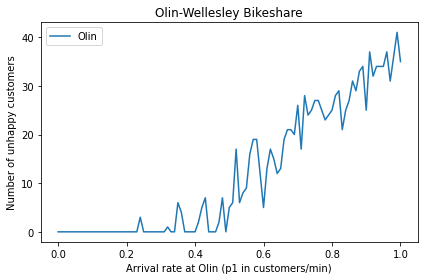

In [23]:
# Solution

from modsim import decorate

p1_array = linspace(0, 1, 101)
sweep = sweep_p1(p1_array)
plot(sweep, label='Olin')
decorate(title='Olin-Wellesley Bikeshare',
         xlabel='Arrival rate at Olin (p1 in customers/min)', 
         ylabel='Number of unhappy customers')

**Exercise:** Write a function called `sweep_p2` that runs simulations with `p1=0.5` and a range of values for `p2`.  It should store the results in a `SweepSeries` and return the `SweepSeries`.


In [24]:
# Solution

def sweep_p2(p2_array):
    p1 = 0.5
    num_steps = 60
    sweep = SweepSeries()
    
    for p2 in p2_array:
        state = run_simulation(p1, p2, num_steps)
        sweep[p2] = state.olin_empty
        
    return sweep

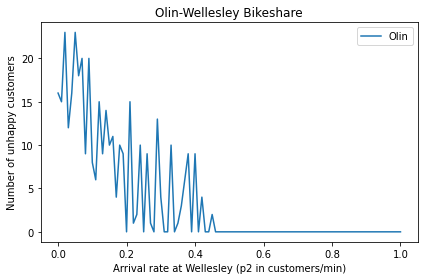

In [25]:
# Solution

p2_array = linspace(0, 1, 101)
sweep = sweep_p2(p2_array)
plot(sweep, label='Olin')

decorate(title='Olin-Wellesley Bikeshare',
         xlabel='Arrival rate at Wellesley (p2 in customers/min)', 
         ylabel='Number of unhappy customers')

## Optional Exercises

The following two exercises are a little more challenging.  If you are comfortable with what you have learned so far, you should give them a try.  If you feel like you have your hands full, you might want to skip them for now.

**Exercise:** Because our simulations are random, the results vary from one run to another, and the results of a parameter sweep tend to be noisy.  We can get a clearer picture of the relationship between a parameter and a metric by running multiple simulations with the same parameter and taking the average of the results.

Write a function called `run_multiple_simulations` that takes as parameters `p1`, `p2`, `num_steps`, and `num_runs`.

`num_runs` specifies how many times it should call `run_simulation`.

After each run, it should store the total number of unhappy customers (at Olin or Wellesley) in a `TimeSeries`.
At the end, it should return the `TimeSeries`.

Test your function with parameters

```
p1 = 0.3
p2 = 0.3
num_steps = 60
num_runs = 10
```

Display the resulting `TimeSeries` and use the `mean` function from NumPy to compute the average number of unhappy customers.

In [42]:
# Solution

def run_multiple_simulations(p1, p2, num_steps, num_runs):
    totals = TimeSeries()
    
    for i in range(num_runs):
        state = run_simulation(p1, p2, num_steps)
        totals[i] = state.olin_empty + state.wellesley_empty
        
    return totals

In [43]:
# Solution

from modsim import show

p1 = 0.3
p2 = 0.3
num_steps = 60
num_runs = 10
totals = run_multiple_simulations(p1, p2, num_steps, num_runs)
show(totals)

,Quantity
Time,
0,7
1,3
2,1
3,3
4,4
5,5
6,2
7,3
8,0


In [44]:
# Solution

mean(totals)

2.8

**Exercise:**  Continuting the previous exercise, use `run_multiple_simulations` to run simulations with a range of values for `p1` and

```
p2 = 0.3
num_steps = 60
num_runs = 20
```

Store the results in a `SweepSeries`, then plot the average number of unhappy customers as a function of `p1`.  Label the axes.

What value of `p1` minimizes the average number of unhappy customers?

In [45]:
# Solution

p1_array = linspace(0, 1, 20)
p2 = 0.3
num_steps = 60
num_runs = 20

sweep = SweepSeries()
for p1 in p1_array:
    totals = run_multiple_simulations(p1, p2, num_steps, num_runs)
    sweep[p1] = mean(totals)

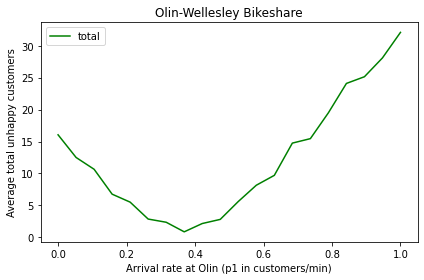

In [46]:
# Solution

plot(sweep, label='total', color='green')
    
decorate(title='Olin-Wellesley Bikeshare',
         xlabel='Arrival rate at Olin (p1 in customers/min)', 
         ylabel='Average total unhappy customers')